In [55]:
from typing import List
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings("ignore")

In [56]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [57]:
df = pd.read_csv("/content/drive/MyDrive/INDONESIA AI/DWIMAS ARIE/SALES FORECASTING/store5.csv")

In [58]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [59]:
cols_drop = ["id","store_nbr","dcoilwtico"]
df = df.drop(cols_drop,axis=1)

In [60]:
df["date"] = pd.to_datetime(df["date"],format="%Y-%m-%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   family       55572 non-null  object        
 2   sales        55572 non-null  float64       
 3   onpromotion  55572 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [61]:
df.head()

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.0,0
1,2013-01-01,BABY CARE,0.0,0
2,2013-01-01,BEAUTY,0.0,0
3,2013-01-01,BEVERAGES,0.0,0
4,2013-01-01,BOOKS,0.0,0


In [62]:
def filter_family(df: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df = df[df["family"]==family].reset_index(drop=True)
    return filtered_df


def adfuller_test(df : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df = df.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df = diff_df.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")


In [63]:
df_poultry = filter_family(df,"POULTRY")
df_poultry.head()

,date,family,sales,onpromotion
0,2013-01-01,POULTRY,0.00000,0
1,2013-01-02,POULTRY,311.91300,0
2,2013-01-03,POULTRY,196.45900,0
3,2013-01-04,POULTRY,167.29599,0
4,2013-01-05,POULTRY,226.04400,0


<Axes: xlabel='date'>

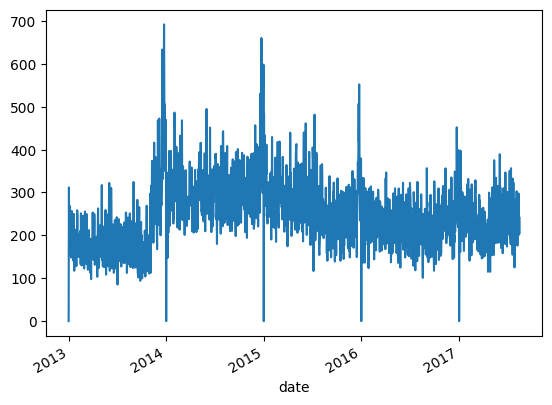

In [64]:
df_poultry.set_index("date").sales.plot()

<Axes: xlabel='date'>

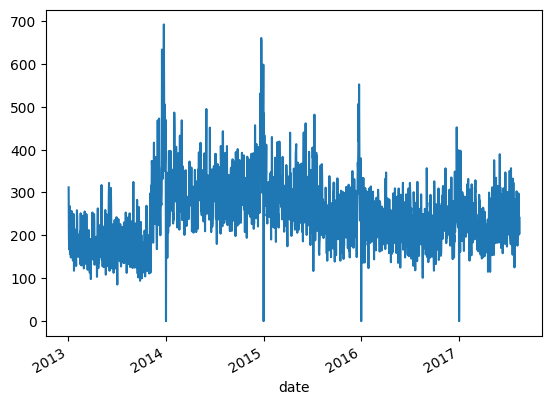

In [65]:
df_poultry.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()

In [66]:
# Mengatur kolom 'date' sebagai indeks
#df_poultry.set_index("date", inplace=True)

# Memperlebar visual plot dan memberi nama plot
#plt.figure(figsize=(14, 7))  # Memperlebar visual plot dengan ukuran 14x7
#df_poultry['sales'].plot()
#plt.title("DATA POULTRY")  # Memberi nama plot
#plt.xlabel("Date")  # Memberi label pada sumbu x
#plt.ylabel("Sales")  # Memberi label pada sumbu y
#plt.show()

<Axes: xlabel='date'>

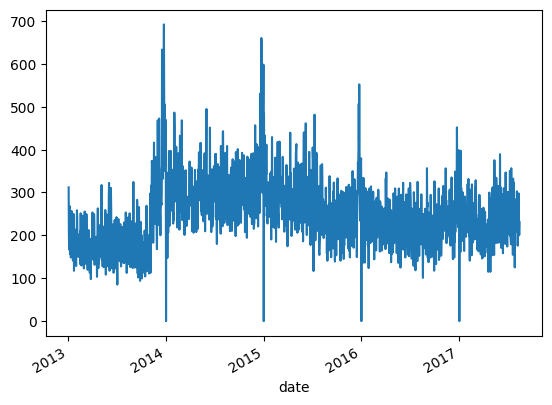

In [67]:
df_poultry = df_poultry.iloc[1:-1,:].reset_index(drop=True)
df_poultry.set_index("date").sales.plot()

<Axes: xlabel='date'>

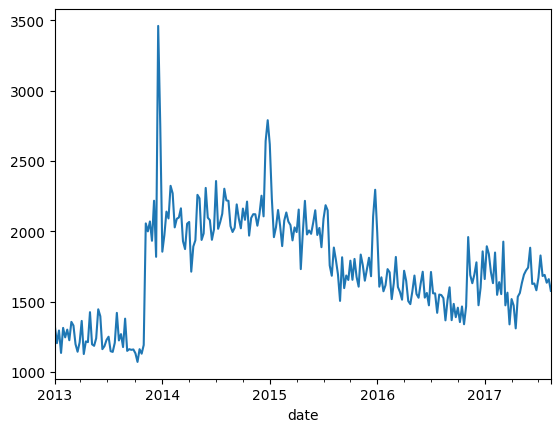

In [68]:
df_poultry.set_index("date").sales.resample("W-MON").sum().plot()

In [69]:
df_poultry = df_poultry.set_index("date").sales.resample("W-MON").sum()
df_poultry = np.log(df_poultry)
df_poultry.head()

date
2013-01-07    7.190568
2013-01-14    7.094783
2013-01-21    7.166572
2013-01-28    7.035306
2013-02-04    7.180741
Freq: W-MON, Name: sales, dtype: float64

In [70]:
df_poultry.index = pd.date_range(start=df_poultry.index.min(), end=df_poultry.index.max(), freq='W-MON')

In [71]:
adfuller_test(df_poultry,4)

Differencing level 0
p-value : 0.2452788192999527
Differencing level 1
p-value : 1.7229265228217136e-09
Differencing level 2
p-value : 8.85795335840288e-13
Differencing level 3
p-value : 1.2812022147204662e-14
Differencing level 4
p-value : 4.7520481978080244e-17


<Axes: >

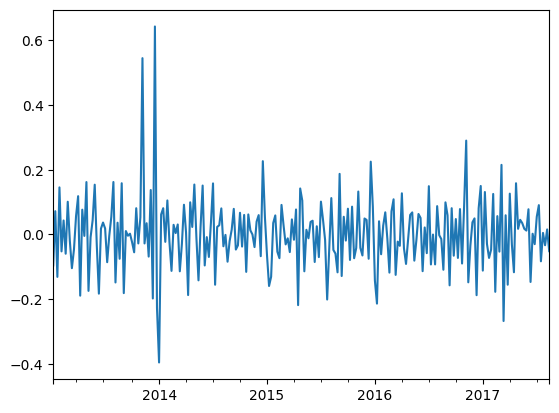

In [72]:
df_poultry.diff().dropna().plot()

<Axes: >

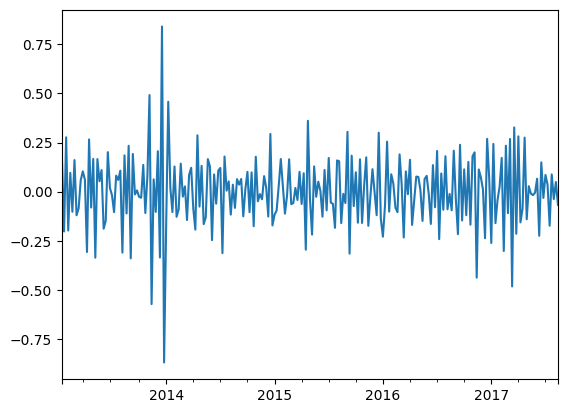

In [73]:
df_poultry.diff().diff().dropna().plot()

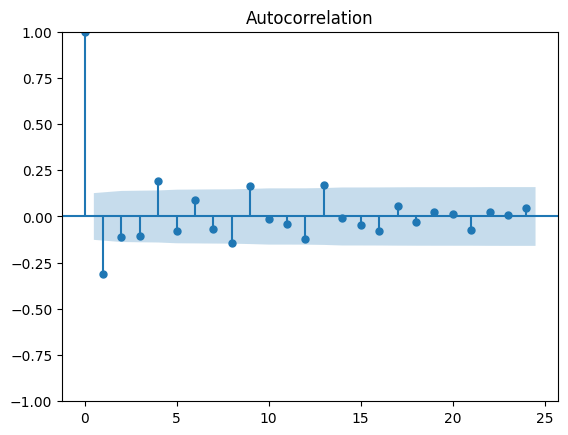

In [74]:
plot_acf(df_poultry.diff().dropna());

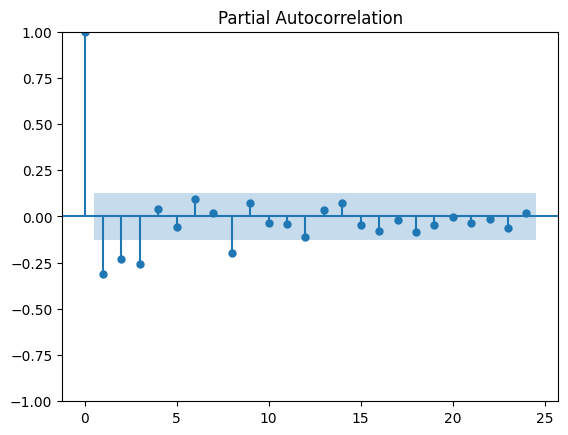

In [75]:
plot_pacf(df_poultry.diff().dropna());

In [76]:
train_date = int(len(df_poultry)*0.98)
train_date

236

In [77]:
df_poultry.iloc[:train_date]

2013-01-07    7.190568
2013-01-14    7.094783
2013-01-21    7.166572
2013-01-28    7.035306
2013-02-04    7.180741
                ...   
2017-06-12    7.393993
2017-06-19    7.396078
2017-06-26    7.365998
2017-07-03    7.420770
2017-07-10    7.511288
Freq: W-MON, Name: sales, Length: 236, dtype: float64

In [78]:
train_data = df_poultry.iloc[:train_date]
test_data = df_poultry.iloc[train_date:]

In [79]:
arima_model_1  = ARIMA(train_data, order=(3,1,1))
model_1 = arima_model_1.fit()

print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  236
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 204.281
Date:                Mon, 24 Jun 2024   AIC                           -398.562
Time:                        12:35:17   BIC                           -381.264
Sample:                    01-07-2013   HQIC                          -391.589
                         - 07-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7254      0.272     -2.668      0.008      -1.258      -0.193
ar.L2         -0.4332      0.120     -3.622      0.000      -0.668      -0.199
ar.L3         -0.3155      0.072     -4.377      0.0

In [80]:
train_pred = model_1.predict(start=train_data.index.min(), end=train_data.index.max(),typ="linear")
train_pred = pd.DataFrame(train_pred)
train_pred

,predicted_mean
2013-01-07,0.000000
2013-01-14,7.190568
2013-01-21,7.124637
2013-01-28,7.160938
2013-02-04,7.093777
...,...
2017-06-12,7.502113
2017-06-19,7.429997
2017-06-26,7.423281
2017-07-03,7.415721


In [81]:
predict_train = pd.merge(train_data,train_pred,left_index=True, right_index=True)

rmse_score = mse(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean),squared=False)
print(f"{rmse_score}")

213.5410122379619


In [82]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape_train = mape(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean)) * 100
print(f"Percent error {mape_train.round(2)}")

Percent error 7.33


In [83]:
test_pred = model_1.predict(start=test_data.index.min(), end=test_data.index.max(),typ="linear")
test_pred = pd.DataFrame(test_pred)
test_pred

,predicted_mean
2017-07-17,7.467058
2017-07-24,7.442651
2017-07-31,7.450955
2017-08-07,7.469459
2017-08-14,7.460140


In [84]:
predict_test = pd.merge(test_data,test_pred,left_index=True, right_index=True)
display(predict_test)


rmse_score = mse(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean),squared=False)
print(f"{rmse_score}")

mape_test = mape(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean)) * 100
print(f"Percent error {mape_test.round(2)}")

,sales,predicted_mean
2017-07-17,7.428201,7.467058
2017-07-24,7.432874,7.442651
2017-07-31,7.399450,7.450955
2017-08-07,7.414905,7.469459
2017-08-14,7.363141,7.460140


96.59667408348481
Percent error 5.2


In [85]:
def plot_predictions(predict_train: pd.DataFrame, predict_test: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))


    plt.plot(predict_train.index, np.exp(predict_train['sales']), color='green', label='Train Actual')
    plt.plot(predict_train.index, np.exp(predict_train['predicted_mean']), color='red', label='Train Predicted')


    plt.plot(predict_test.index, np.exp(predict_test['sales']), color='yellow', label='Test Actual')
    plt.plot(predict_test.index, np.exp(predict_test['predicted_mean']), color='blue', label='Test Predicted')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Actual vs Predicted Sales')
    plt.legend()
    plt.show()

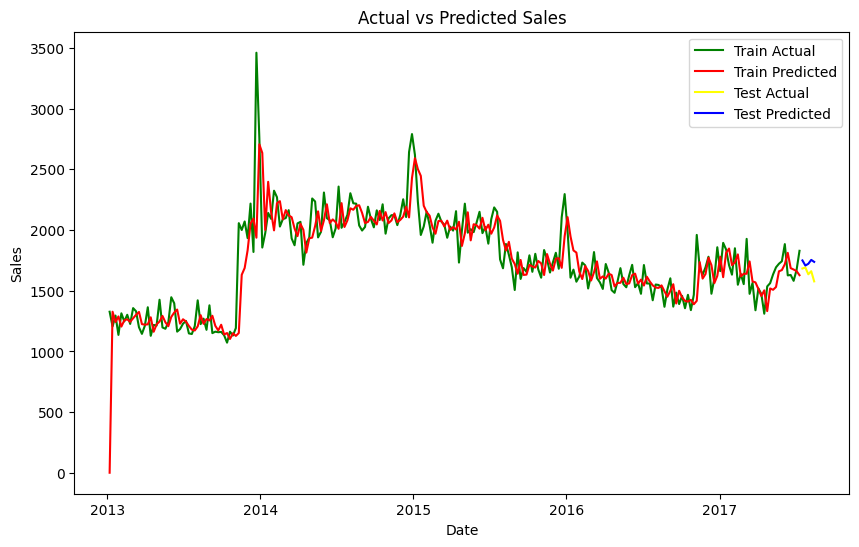

In [86]:
plot_predictions(predict_train, predict_test)